In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#import seaborn as sns

In [3]:
# prepare target

def Dummies_Corrected(Data,Test):
    train_objs_num = len(Data)
    combined = pd.concat([Data, Test], axis=0)
    df = pd.get_dummies(combined)
    Data[:] = df[:train_objs_num]
    Test[:] = df[train_objs_num:]
    print(Data)

def Categorize(Data):
    for x in Data.columns:
        if(Data[x].dtype == object):
            Data[x] = pd.Categorical(
        Data[x])


In [30]:
def find_outliers(Data, col):
    data_mean, data_std = np.mean(Data[col]), np.std(Data[col])
    cut_off = data_std * 4
    lower, upper = data_mean - cut_off, data_mean + cut_off
    return Data.loc[(Data[col]<lower) | (Data[col]>upper), col ] #.index



In [51]:
SEED = 7
np.random.seed(SEED)

In [23]:
X_train = pd.read_csv('TrainingDataFeaturescd.csv', 
                 index_col = 0)
X_copy = X_train.copy()

# X_test = pd.read_csv('TrainingDataFeatures.csv', 
#                  index_col = 0)
# X_test_copy = X_test.copy()

In [24]:
Y_train = X_train['Total52'].copy()
# Y_test = X_test['Total52'].copy()

X_train.drop('Total52', axis = 1 ,inplace = True)
# X_test.drop('Total52', axis = 1 ,inplace = True)

In [25]:
Categorize(X_train)
# Categorize(X_test)
# Dummies_Corrected(X_train,X_test)

X_train = pd.get_dummies(X_train, drop_first = False)

In [26]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test =train_test_split(X_train,Y_train,
                                                   test_size=0.33,
                                                   random_state = SEED,
                                                   stratify=Y_train)

In [27]:
# from sklearn.utils import shuffle

# x_train, y_train = shuffle(X_train, Y_train, random_state = SEED)
# x_test , y_test = X_test, Y_test

In [35]:
# feature selection
from sklearn.feature_selection import SelectFromModel, SelectKBest, mutual_info_classif, mutual_info_regression, chi2
from sklearn.ensemble import RandomForestClassifier

def select_mutual(X_train, y_train, X_test, k=10):
    fs = SelectKBest(score_func=mutual_info_regression, k=k)
    X_train = fs.fit_transform(X_train, y_train)
    X_test = fs.transform(X_test)
    return X_train, X_test

def select_forest(X_train, y_train, X_test, k=10):
    clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
    clf.fit(X_train, y_train)
    sfm = SelectFromModel(clf, threshold=-np.inf,max_features=k)
    X_train=sfm.fit_transform(X_train, y_train)
    X_test = sfm.transform(X_test)
    return X_train, X_test

def select_chi2(X_train, y_train, X_test, k=10):
    fs = SelectKBest(score_func=chi2, k=k)
    X_train = fs.fit_transform(X_train, y_train)
    X_test = fs.transform(X_test)
    return X_train, X_test

# OPTIONS OF RUNNING

In [32]:
# OPTIONS OF RUNNING

# Normal

# **********

# WITHOUT OUTLIERS

#X_test = X_test_copy.copy()
# X_train = X_copy.copy()
# X_train = X_train.drop( find_outliers(X_train,'algo').index )
# Y_train = X_train['Total52'].copy()

# x_train, x_test, y_train, y_test =train_test_split(X_train,Y_train,
#                                                    test_size=0.33,
#                                                    random_state = SEED,
#                                                    stratify=Y_train)

# Non linear?

# from sklearn.preprocessing import PolynomialFeatures
# poly = PolynomialFeatures(2)
# x_train = poly.fit_transform(x_train)
# x_test = poly.transform(x_test)

# # PCA 
# from sklearn.decomposition import PCA

# pca = PCA(.99)
# x_train = pca.fit_transform(x_train)
# x_test = pca.transform(x_test);

# Hashing

# from sklearn.feature_extraction import FeatureHasher
# # si input_type = 'dict' Either “dict” (the default) to accept dictionaries over (feature_name, value);
# h = FeatureHasher(n_features=5, input_type='string')
# f = h.transform(new_class)
# f.toarray()

NameError: name 'RandomForestClassifier' is not defined

In [36]:
# Selecting features
x_train, x_test = select_forest(x_train,y_train,x_test)

In [37]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate

def BasedLine2(X_train, y_train,models):
    # Test options and evaluation metric
    num_folds = 5
    

    results = []
    names = []
    for name, model in models:
        kfold = StratifiedKFold(n_splits=num_folds, random_state=SEED, shuffle = True)
      # classification scoring = ['f1_micro','accuracy','average_precision_score', 'recall']
        scoring = ['explained_variance','r2','max_error','neg_root_mean_squared_error']
        
        cv_results = cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring,
                                  return_train_score = False)
        results.append(cv_results)
        names.append(name)
    #    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  #      print(msg)
        #print(np.mean(cv_results) )
        
    return names, results

def ScoreDataFrame(names,results):

    pd.options.display.float_format = '{:,.2f}'.format
    scores = []
    for r in range(len(results)):
        scores.append(pd.DataFrame(results[r]).mean())
    scoreDataFrame = pd.DataFrame(scores,index = names)
    return scoreDataFrame


In [107]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from math import ceil
from sklearn.pipeline import Pipeline

alpha = 2
if(Y_train.ndim>1):
    Nh = ceil( X_train.shape[0]/(alpha * (X_train.shape[1]+Y_train.shape[1])) )
else:
    Nh = ceil( X_train.shape[0]/(alpha * (X_train.shape[1])) )

max_iter=250

def GetScaledModel(nameOfScaler):
    
    if nameOfScaler == 'standard':
        scaler = StandardScaler()
    elif nameOfScaler =='minmax':
        scaler = MinMaxScaler()

    pipelines = []
    pipelines.append((nameOfScaler+'LR'  , Pipeline([('Scaler', scaler),('LR'  , LogisticRegression(max_iter=max_iter))])))
    pipelines.append((nameOfScaler+'LDA' , Pipeline([('Scaler', scaler),('LDA' , LinearDiscriminantAnalysis())])))
    pipelines.append((nameOfScaler+'KNN' , Pipeline([('Scaler', scaler),('KNN' , KNeighborsClassifier())])))
    pipelines.append((nameOfScaler+'CART', Pipeline([('Scaler', scaler),('CART', DecisionTreeClassifier())])))
    pipelines.append((nameOfScaler+'NB'  , Pipeline([('Scaler', scaler),('NB'  , GaussianNB())])))
    pipelines.append((nameOfScaler+'SVM' , Pipeline([('Scaler', scaler),('SVM' , SVC(max_iter=max_iter))])))
    pipelines.append((nameOfScaler+'AB'  , Pipeline([('Scaler', scaler),('AB'  , AdaBoostClassifier())])  ))
 #   pipelines.append((nameOfScaler+'GBM' , Pipeline([('Scaler', scaler),('GMB' , GradientBoostingClassifier())])  ))
    pipelines.append((nameOfScaler+'RF'  , Pipeline([('Scaler', scaler),('RF'  , RandomForestClassifier())])  ))
    pipelines.append((nameOfScaler+'ET'  , Pipeline([('Scaler', scaler),('ET'  , ExtraTreesClassifier())])  ))
    
    pipelines.append((nameOfScaler+'MLP'  , Pipeline([('Scaler', scaler),
                                                      ('MLP'  , MLPClassifier(
                                                          hidden_layer_sizes = Nh,
                                                          activation= 'relu',
                                                          solver = 'adam',
                                                          early_stopping=True,
                                                          max_iter=max_iter,
                                                          ))])  ))

    return pipelines 

In [137]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
from math import ceil
from sklearn.pipeline import Pipeline

alpha = 2
if(Y_train.ndim>1):
    Nh = ceil( X_train.shape[0]/(alpha * (X_train.shape[1]+Y_train.shape[1])) )
else:
    Nh = ceil( X_train.shape[0]/(alpha * (X_train.shape[1])) )

max_iter=250

def GetScaledModel_Regression(nameOfScaler):
    
    if nameOfScaler == 'standard':
        scaler = StandardScaler()
    elif nameOfScaler =='minmax':
        scaler = MinMaxScaler()

    pipelines = []
    pipelines.append((nameOfScaler+'LR'  , Pipeline([('Scaler', scaler),('LR'  , LogisticRegression(max_iter=max_iter))])))
    pipelines.append((nameOfScaler+'LDA' , Pipeline([('Scaler', scaler),('LDA' , LinearDiscriminantAnalysis())])))
    pipelines.append((nameOfScaler+'KNN' , Pipeline([('Scaler', scaler),('KNN' , KNeighborsRegressor())])))
    pipelines.append((nameOfScaler+'CART', Pipeline([('Scaler', scaler),('CART', DecisionTreeRegressor())])))
    pipelines.append((nameOfScaler+'NB'  , Pipeline([('Scaler', scaler),('NB'  , GaussianNB())])))
    pipelines.append((nameOfScaler+'SVM' , Pipeline([('Scaler', scaler),('SVM' , SVC(max_iter=max_iter))])))
    pipelines.append((nameOfScaler+'AB'  , Pipeline([('Scaler', scaler),('AB'  , AdaBoostRegressor())])  ))
 #   pipelines.append((nameOfScaler+'GBM' , Pipeline([('Scaler', scaler),('GMB' , GradientBoostingRegressor())])  ))
    pipelines.append((nameOfScaler+'RF'  , Pipeline([('Scaler', scaler),('RF'  , RandomForestRegressor())])  ))
    pipelines.append((nameOfScaler+'ET'  , Pipeline([('Scaler', scaler),('ET'  , ExtraTreesRegressor())])  ))
    
    pipelines.append((nameOfScaler+'MLP'  , Pipeline([('Scaler', scaler),
                                                      ('MLP'  , MLPRegressor(
                                                          hidden_layer_sizes = Nh,
                                                          activation= 'relu',
                                                          solver = 'adam',
                                                          early_stopping=True,
                                                          max_iter=max_iter,
                                                          ))])  ))

    return pipelines 

In [138]:
models = GetScaledModel('standard')
names,results = BasedLine2(x_train, y_train,models)
scaledScoreStandard = ScoreDataFrame(names,results)

C:\Users\didio\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\didio\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\didio\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\didio\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\didio\Anaconda3\lib\site-packag

In [142]:
scaledScoreStandard

,fit_time,score_time,test_explained_variance,test_r2,test_max_error,test_neg_root_mean_squared_error
standardLR,1.85,0.00,0.28,0.17,-40.80,-7.44
standardLDA,0.02,0.00,0.21,0.19,-41.40,-7.35
standardKNN,0.03,0.07,0.28,0.18,-40.80,-7.41
standardCART,0.02,0.00,0.03,0.02,-41.00,-8.08
standardNB,0.01,0.01,-2.80,-5.83,-41.00,-21.32
standardSVM,0.90,0.32,0.26,0.13,-40.80,-7.61
standardAB,0.62,0.05,-0.83,-0.94,-42.20,-11.15
standardRF,0.69,0.06,0.03,0.02,-41.00,-8.09
standardET,1.44,0.07,0.06,0.04,-40.60,-8.00
standardMLP,2.60,0.01,0.29,0.17,-40.80,-7.45


In [72]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, truncnorm, randint

# classification score = ['f1_micro','accuracy','average_precision_score', 'recall']
# score = ['explained_variance','r2','max_error','neg_root_mean_squared_error']
score = 'r2'
        

In [152]:
# First Scalling
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
x_train = stdsc.fit_transform(x_train)
x_test = stdsc.transform(x_test)

## Random Forest

In [83]:
# rf_param_grid = {
#                  'max_depth' : [3,20,50],
#                  'n_estimators': [100,1000,2000],
#                  'max_features': ['sqrt','auto','log2'],
#                  'min_samples_split': [2,6,8],
#                  'min_samples_leaf': [2,6,8],
#                  'bootstrap': [True, False]
#                  }

rf_param_grid = {
    # randomly sample numbers from 4 to 204 estimators
    'n_estimators': randint(4,200),
    # normally distributed max_features, with mean .25 stddev 0.1, bounded between 0 and 1
    'max_features': truncnorm(a=0, b=1, loc=0.25, scale=0.1), # 0 to 25% obs
    # uniform distribution from 0.01 to 0.2 (0.01 + 0.199)
    'min_samples_split': uniform(0.00and1, 0.199) # 0 to 20% obs
}

In [85]:
rf_model = RandomForestClassifier()

clf = RandomizedSearchCV(rf_model, rf_param_grid, n_iter=100, cv=5, random_state=SEED, scoring = score)
model = clf.fit(x_train, y_train)
rf_best = model.best_estimator_.get_params()
print(pd.DataFrame(rf_best))
cv_results = model.cv_results_
scores = pd.DataFrame(cv_results).sort_values(by='rank_test_score')
scores

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 0.32050095083279484, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 0.0114215117805207, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 168, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
41           0.50          0.02             0.07            0.00   
79           0.06          0.00             0.01            0.00   
55           0.42          0.03             0.06            0.00   
77           0.29          0.00             0.04            0.00   
3            0.19          0.00             0.03            0.00   
7            0.60          0.06             0.08            0.01   
90           0.06          0.00             0.01            0.00   
38   

In [86]:
scores

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
41,0.50,0.02,0.07,0.00,0.32,0.01,168,"{'max_features': 0.32050095083279484, 'min_sam...",0.14,0.19,0.16,0.13,0.17,0.16,0.02,1
79,0.06,0.00,0.01,0.00,0.28,0.01,20,"{'max_features': 0.2837380993015824, 'min_samp...",0.17,0.17,0.13,0.15,0.17,0.16,0.02,2
55,0.42,0.03,0.06,0.00,0.25,0.01,147,"{'max_features': 0.2538312475450465, 'min_samp...",0.13,0.18,0.14,0.14,0.17,0.15,0.02,3
77,0.29,0.00,0.04,0.00,0.27,0.01,106,"{'max_features': 0.27087258777091305, 'min_sam...",0.13,0.18,0.15,0.13,0.15,0.15,0.02,4
3,0.19,0.00,0.03,0.00,0.29,0.01,72,"{'max_features': 0.28668927780580344, 'min_sam...",0.14,0.16,0.13,0.13,0.16,0.14,0.01,5
7,0.60,0.06,0.08,0.01,0.34,0.01,193,"{'max_features': 0.34072484358174615, 'min_sam...",0.13,0.15,0.12,0.14,0.15,0.14,0.01,6
90,0.06,0.00,0.01,0.00,0.28,0.02,22,"{'max_features': 0.2772896908183179, 'min_samp...",0.13,0.15,0.12,0.12,0.12,0.13,0.01,7
38,0.03,0.00,0.00,0.00,0.31,0.02,10,"{'max_features': 0.3097341375344037, 'min_samp...",0.12,0.09,0.08,0.14,0.15,0.12,0.03,8
76,0.48,0.01,0.06,0.00,0.32,0.02,174,"{'max_features': 0.3195648148304188, 'min_samp...",0.12,0.11,0.10,0.11,0.11,0.11,0.00,9
86,0.40,0.02,0.06,0.00,0.29,0.03,175,"{'max_features': 0.28902776172562983, 'min_sam...",0.11,0.09,0.09,0.11,0.11,0.10,0.01,10


## 5.1.Logistic Regression
- C : Regularization value, the more, the stronger the regularization(double). 
- RegularizationType: Can be either "L2" or “L1”. Default is “L2”. 

In [ ]:
LR_param_grid = {
    # randomly sample numbers from 4 to 204 estimators
    'penalty' : ['l1', 'l2'],
    # normally distributed max_featur,es, with mean .25 stddev 0.1, bounded between 0 and 1
    'C' : uniform(0,4)
    # uniform distribution from 0.01 to 0.2 (0.01 + 0.199)
    'min_samples_split': uniform(0.01, 0.199) # 0 to 20% obs
}

In [ ]:
LR_model = LogisticRegression()

clf = RandomizedSearchCV(LR_model, LR_param_grid, n_iter=100, cv=5, random_state=SEED, score = score)
model = clf.fit(x_train, y_train)
lr_best = model.best_estimator_.get_params()
print(lr_best)
cv_results = model.cv_results_
scores = pd.DataFrame(cv_results).sort_values(by='rank_test_score')
print(scores)

## 5.6 GradientBoosting - if you have time!

In [ ]:
# Hyperparameter grid
# gbm_param_grid = {
#     'boosting_type': ['gbdt', 'goss', 'dart'],
#     'num_leaves': list(range(20, 150)),
#     'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000)),
#     'subsample_for_bin': list(range(20000, 300000, 20000)),
#     'min_child_samples': list(range(20, 500, 5)),
#     'reg_alpha': list(np.linspace(0, 1)),
#     'reg_lambda': list(np.linspace(0, 1)),
#     'colsample_bytree': list(np.linspace(0.6, 1, 10)),
#     'subsample': list(np.linspace(0.5, 1, 100)),
#     'is_unbalance': [True, False]
# }

gbm_param_grid = {
    'learning_rate_value' = uniform(0,1),
    'n_estimators_value' = randint(50,300)
}

In [ ]:
gb_model = GradientBoostingClassifier()

clf = RandomizedSearchCV(gb_model, gb_param_grid, n_iter=100, cv=5, random_state=SEED, score = score)
model = clf.fit(x_train, y_train)
gb_best = model.best_estimator_.get_params()
print(gb_best)
cv_results = model.cv_results_
scores = pd.DataFrame(cv_results).sort_values(by='rank_test_score')
print(scores)

## 5.2. KNN
- n_neighbors: Number of neighbors to use by default for k_neighbors queries

In [ ]:
knn_param_grid = {
'neighbors' : randint(1,20)
}


In [ ]:

KN_model = KNeighborsClassifier()()

clf = RandomizedSearchCV(KN_model, knn_param_grid, n_iter=100, cv=5, random_state=SEED, score = score)
model = clf.fit(x_train, y_train)
kn_best = model.best_estimator_.get_params()
print(kn_best)
cv_results = model.cv_results_
scores = pd.DataFrame(cv_results).sort_values(by='rank_test_score')
print(scores)


## 5.3. SVC 
- C: The Penalty parameter C of the error term. 
- Kernel: Kernel type could be linear, poly, rbf or sigmoid.

In [ ]:
svc_param_grid = {
    'c_values' : uniform(0,3),
    'kernel_values' : [ 'linear' , 'poly' , 'rbf' , 'sigmoid' ]
}

In [ ]:
svc_model = SVC()()

clf = RandomizedSearchCV(svc_model, svc_param_grid, n_iter=100, cv=5, random_state=SEED, score = score)
model = clf.fit(x_train, y_train)
svc_best = model.best_estimator_.get_params()
print(svc_best)
cv_results = model.cv_results_
scores = pd.DataFrame(cv_results).sort_values(by='rank_test_score')
print(scores)

## 5.3. MLP

In [76]:
from scipy.stats import rv_discrete
rv_discrete(name='truncnorm', values=(Nh/4, 5*Nh, Nh, Nh))

ValueError: too many values to unpack (expected 2)

In [184]:


# Binomial(n, p) ~ Normal(n*p, sqrt(n*p*(1-p)))
# bi = np.random.binomial(n=100, p=0.5, size=10000)


mlp_param_grid = {
    'hidden_layer_sizes': randint(Nh/4,5*Nh),
    'activation': ['relu'],
    'solver': ['sgd', 'adam'],
    'alpha': uniform(1e-4,1),
    'learning_rate': ['constant','adaptive']
    ,'learning_rate_init': uniform(1e-3,1)
}

328

In [185]:
mlp_model = MLPRegressor(max_iter=100)

clf = RandomizedSearchCV(mlp_model, mlp_param_grid, n_iter=10, cv=5, random_state=SEED, scoring = score, verbose = 1)
model = clf.fit(x_train, y_train)
mlp_best = model.best_estimator_.get_params()
print(mlp_best)
cv_results = model.cv_results_
scores = pd.DataFrame(cv_results).sort_values(by='rank_test_score')
scores

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\didio\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\didio\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\didio\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\didio\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations

C:\Users\didio\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\didio\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\didio\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\didio\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': 1181, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 100, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'sgd', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}


C:\Users\didio\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


NameError: name 'socres' is not defined

In [181]:
np.where(np.isnan(x_train))

(array([], dtype=int64),)

In [180]:
np.where(np.isinf(x_train))

(array([], dtype=int64),)

In [186]:
mlp_best['max_iter'] = 300
mlp = MLPRegressor(**mlp_best)
mlp.fit(x_train, y_train)

C:\Users\didio\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=1181, learning_rate='adaptive',
             learning_rate_init=0.001, max_fun=15000, max_iter=300,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='sgd',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002488C597550>,
      dtype=object)

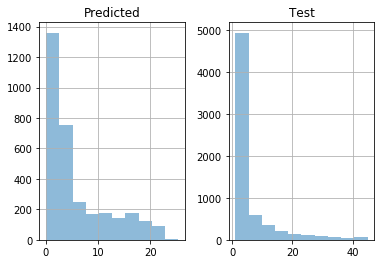

In [188]:
y_pred = mlp.predict(x_test)
pd.DataFrame([y_pred,y_train],['Predicted','Test']).T.hist( alpha = 0.5)

In [ ]:
# Repport
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


confusion_matrix(y_true, y_pred ) #, labels=["ant", "bird", "cat"])

print(classification_report(y_test, y_pred ) )  #,target_names=target_names))


# explained_variance_score(y_test, y_pred)
# metrics.r2_score(y_test, y_pred)
# metrics.mean_squared_error(y_test, y_pred, squared = False)

In [ ]:
pd.DataFrame([y_pred,y_train],['Predicted','Test']).T.hist( alpha = 0.5)

In [ ]:
# VOTIIING

In [ ]:
from sklearn.ensemble import VotingClassifier

model1 = LogisticRegression(**lr_best)

model8 = RandomForestClassifier(**rf_best)

model2 = KNeighborsClassifier(**kn_best)

model3 = SVC(**svc_best)

model6 = GradientBoostingClassifier(**gb_best)

model10 = MLPClassifier(**mlp_best)
# max_depth_value = [3, None]
# max_features_value =  randint(1, 4)
# min_samples_leaf_value = randint(1, 4)
# criterion_value = ["gini", "entropy"]
# model4 = DecisionTreeClassifier(**param)

# learning_rate_value = [.01,.05,.1,.5,1]
# n_estimators_value = [50,100,150,200,250,300]
# model5 = AdaBoostClassifier(**param)





In [ ]:
# create the sub models
estimators = [('LR',model1), ('KNN',model2), ('SVC',model3),
             # ('DT',model4),
             # ('ADa',model5),
              ('GB',model6),
              ('NB',model7), ('RF',model8) 
              #,('ET',model9)
              ,('MLP',model10)
             ]
    

In [ ]:
# create the ensemble model
kfold = StratifiedKFold(n_splits=10, random_state=SEED)
ensemble = VotingClassifier(estimators)

results = cross_val_score(ensemble, x_train,y_train, cv=kfold)

print('Accuracy on train: ',results.mean())
ensemble_model = ensemble.fit(x_train,y_train)

pred = ensemble_model.predict(X_test)
print('Accuracy on test:' , (y_test == pred).mean())